# CNN Model Training with MNIST Dataset<br>
### By Kenneth Lim

Given that we have this diagram:

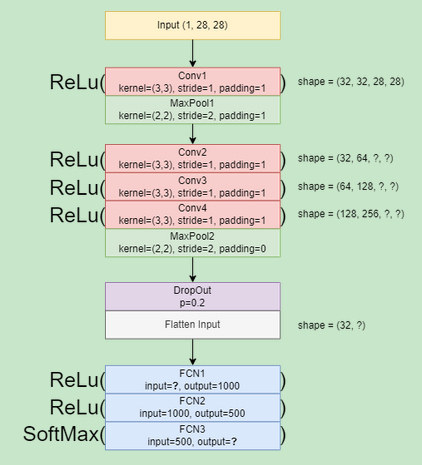

### Coding Pipeline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic=True
torch.set_printoptions(sci_mode=False)

import time
from tqdm.notebook import tqdm

In [ ]:
# `transforms` is used to apply augmentation techniques and modification to the image data (e.g, rotate, resize, normalization, etc.).
# for this one, let's just convert the image arrays to tensor.
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [ ]:
#We will be splitting the datasets into train and validation
train_set, val_set = torch.utils.data.random_split(train_data, [0.8, 0.2])

In [ ]:
# function to set the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

In [ ]:
# For our seed, we will set it to 64
set_seed(64)

batch_size = 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
images, labels = iter(train_loader).__next__()

def display_image(batch):
    batch = batch.detach().numpy()
    fig, axs = plt.subplots(1, len(batch), figsize=(12, 2))
    for i in range(len(batch)):
        axs[i].imshow(batch[i, 0, :, :], vmin=0, vmax=1)
        axs[i].axis('off')
        axs[i].set_title(labels[i].numpy())
    plt.show()

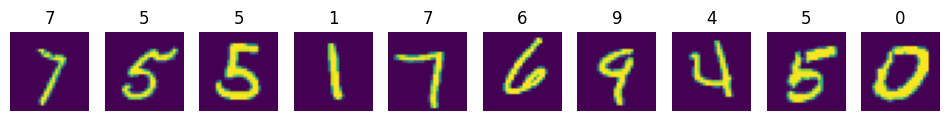

In [ ]:
#Let's see our inputs
display_image(images)

*For further understanding our shape of image contains the following features, (batch size, channels, height, and width)*

In [ ]:
images.shape

torch.Size([10, 1, 28, 28])

*We have the calculation of the output layer defined by (width, filter, shape, padding)*

In [ ]:
def calc_out(w, f, s, p):
    """
    Calculate output shape of a matrix after a convolution.
    The results are only applicable for square matrix kernels and images only.
    """
    print(f'Output Shape: {(w - f + 2 * p) // s + 1}')

In [ ]:
# first maxpooling must output a 14 by 14 size
calc_out(28, 2, 2, 0)

Output Shape: 14


### First Convolution Pipeline

In [ ]:
# The first convolution must output a 28 by 28 image size
calc_out(28, 3, 1, 1)

Output Shape: 28


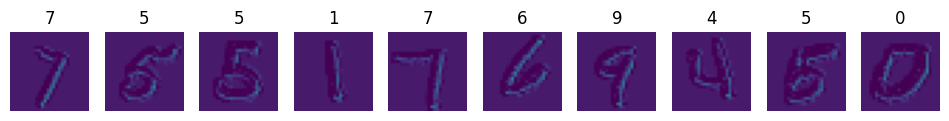

torch.Size([10, 32, 28, 28])


In [ ]:
conv1 = nn.Conv2d(1, 32, (3,3), 1, 1)

x = F.relu(conv1(images))
display_image(x)
print(x.shape)

In [ ]:
# first maxpooling must output a 15 by 15 size
calc_out(28, 2, 2, 1)

Output Shape: 15


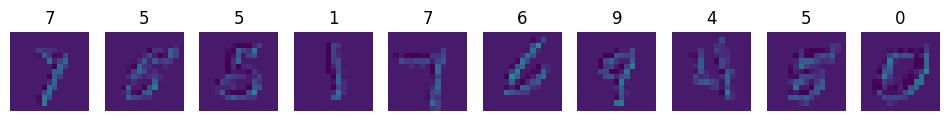

torch.Size([10, 32, 15, 15])


In [ ]:
pool1 = nn.MaxPool2d((2,2), 2, 1)

x = pool1(x)
display_image(x)
print(x.shape)

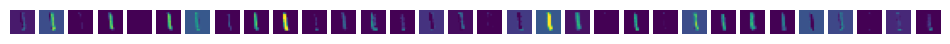

In [ ]:
#Looking at the feature map
idx = 3
feature_maps =  x[idx].view((1, 32, 15, 15)).detach().numpy()
fig, axs = plt.subplots(1, 32, figsize=(12, 2))
for i in range(32):
    axs[i].imshow(feature_maps[0, i, :, :], vmin=0, vmax=1)
    axs[i].axis('off')

### Second Convolution

In [ ]:
calc_out(15, 3, 1, 1)

Output Shape: 15


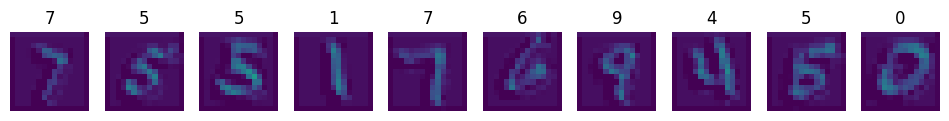

torch.Size([10, 64, 15, 15])


In [ ]:
conv2 = nn.Conv2d(32, 64, (3,3), 1, 1)


x = F.relu(conv2(x))
display_image(x)
print(x.shape)

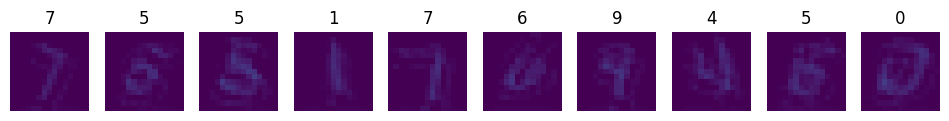

torch.Size([10, 128, 15, 15])


In [ ]:
conv3 = nn.Conv2d(64, 128, (3, 3), 1, 1)


x = F.relu(conv3(x))
display_image(x)
print(x.shape)

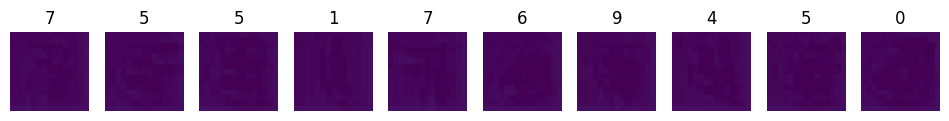

torch.Size([10, 256, 15, 15])


In [ ]:
conv4 = nn.Conv2d(128, 256, (3, 3), 1, 1)

x = F.relu(conv4(x))
display_image(x)
print(x.shape)

In [ ]:
#Our second max pooling
calc_out(15, 2, 2, 0)

Output Shape: 7


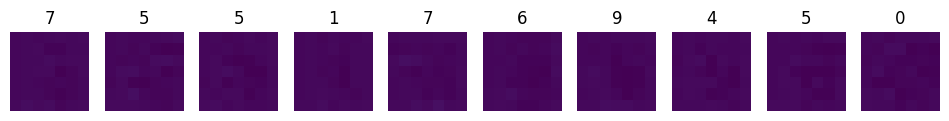

torch.Size([10, 256, 7, 7])


In [ ]:
pool2 = nn.MaxPool2d((2,2), 2)

x = pool2(x)
display_image(x)
print(x.shape)

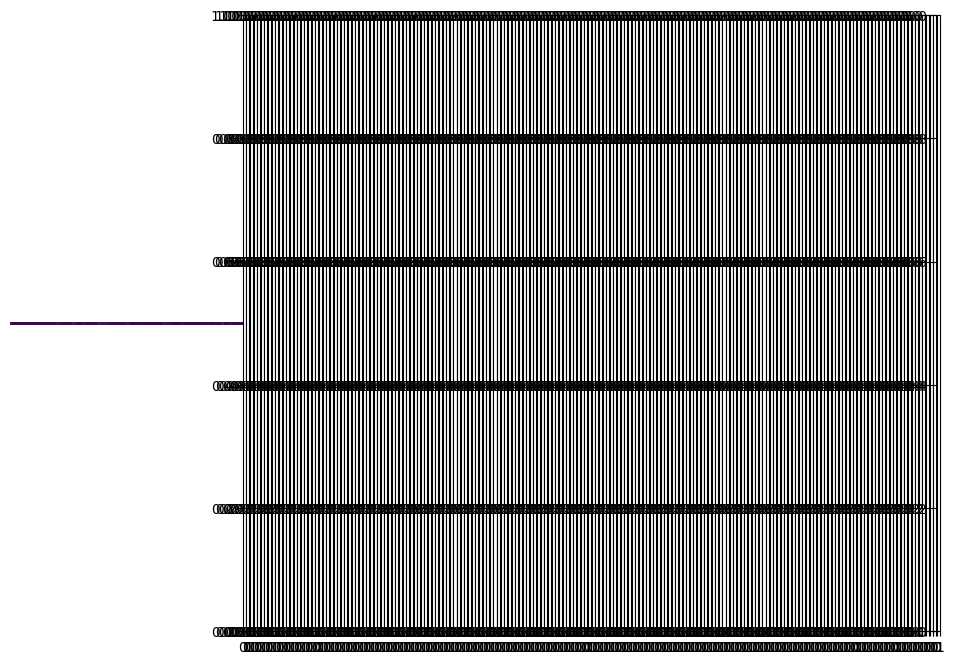

In [ ]:
idx = 3
feature_maps =  x[idx].view((1, 256, 7, 7)).detach().numpy()
fig, axs = plt.subplots(1, 256, figsize=(12, 8))
for i in range(64):
    axs[i].imshow(feature_maps[0, i, :, :], vmin=0, vmax=1)
    axs[i].axis('off')

*The visualization is odd but it is clear that we have 256 channels in this case*

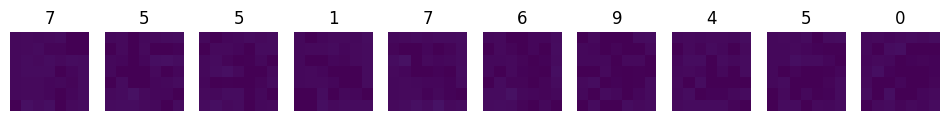

torch.Size([10, 256, 7, 7])

In [ ]:
# Applying the dropout layer
dropout = nn.Dropout(0.20)

x = dropout(x)
display_image(x)
x.shape

In [ ]:
flat = x.view((-1, 256*7*7))

fcn1 = nn.Linear(256*7*7, 1000)
fcn2 = nn.Linear(1000, 500)
fcn3 = nn.Linear(500, 10)


out = fcn1(flat)
out = fcn2(out)
out = F.softmax(fcn3(out), dim=1)

In [ ]:
# prediction
# assess the prediction
[i.argmax().item() for i in out]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
# true label
[i.item() for i in labels]

[7, 5, 5, 1, 7, 6, 9, 4, 5, 0]

*As of the moment, it is still not learning anything but we will train it now*

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # just the initialization
        self.conv1 = nn.Conv2d(1, 32, (3,3), 1, 1)
        self.pool1 = nn.MaxPool2d((2,2), 2, 1)
        self.conv2 = nn.Conv2d(32, 64, (3,3), 1, 1)
        self.conv3 = nn.Conv2d(64, 128, (3,3), 1, 1)
        self.conv4 = nn.Conv2d(128, 256, (3,3), 1, 1)
        self.dropout = nn.Dropout(0.20)
        self.pool2 = nn.MaxPool2d((2,2), 2)
        self.fcn1 = nn.Linear(256*7*7, 1000)
        self.fcn2 = nn.Linear(1000, 500)
        self.fcn3 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        x = self.fcn3(x)
        return F.softmax(x, dim=1)

        return x

In [ ]:
#Instatiating the class
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcn1): Linear(in_features=12544, out_features=1000, bias=True)
  (fcn2): Linear(in_features=1000, out_features=500, bias=True)
  (fcn3): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   288
    32
 18432
    64
 73728
   128
294912
   256
12544000
  1000
500000
   500
  5000
    10
______
13438350


*In this setup, we have a comically huge 13 million parameters*

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# if your device has cuda enabled gpu, you can use it to accelerate the training process.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

model = model.to(device)

cuda


*Let's start the training loop*

In [ ]:
set_seed(64)
epochs = 5
start_time = time.time()
best_acc = 0.0

train_correct = []
train_losses = []
train_accs = []

val_correct = []
val_losses = []
val_accs = []

for e in range(epochs):
    train_corr = 0
    val_corr = 0

    for train_b, (x_train, y_train) in tqdm(enumerate(train_loader)):
        train_b += 1
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        train_pred = model(x_train)
        train_loss = criterion(train_pred, y_train)

        train_pred_vec = torch.max(train_pred.data, 1)[1] # prediction vector
        train_corr += (train_pred_vec == y_train).sum()

        # Update parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if train_b % 1250 == 0:
            print(f"epoch: {e+1:2} | batch: {train_b:4} | instances: [{train_b*batch_size:6} / {len(train_loader)  * batch_size}] | loss: {train_loss.item()}")
            print(f"✅{train_corr.item()} of {train_b*batch_size:2} | accuracy: {round(((train_corr.item() / (train_b*batch_size))) * 100 , 3)}%")

        train_correct.append(train_corr.item())
        train_losses.append(train_loss.item())

    with torch.no_grad():
        for val_b, (x_val, y_val) in enumerate(val_loader):
            val_b += 1

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            val_pred = model(x_val)
            val_pred_vec = torch.max(val_pred.data, 1)[1]
            val_corr += (val_pred_vec == y_val).sum()

            val_loss = criterion(val_pred, y_val)
            val_correct.append(val_corr.item())
            val_losses.append(val_loss.item())

            val_acc = val_corr.item() / (len(val_loader) * batch_size)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"./model/best_{model._get_name()}.pth")
            print(f"\t📁New best model saved! | accuracy: {best_acc*100}%")

    train_epoch_acc = train_corr.item() / (batch_size * len(train_loader))
    val_epoch_acc = val_corr.item() / (batch_size * len(val_loader))

    train_accs.append(train_epoch_acc)
    val_accs.append(val_epoch_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

0it [00:00, ?it/s]

epoch:  1 | batch: 1250 | instances: [ 12500 / 48000] | loss: 2.3611502647399902
✅1181 of 12500 | accuracy: 9.448%
epoch:  1 | batch: 2500 | instances: [ 25000 / 48000] | loss: 2.3611502647399902
✅2286 of 25000 | accuracy: 9.144%
epoch:  1 | batch: 3750 | instances: [ 37500 / 48000] | loss: 2.4611501693725586
✅3449 of 37500 | accuracy: 9.197%
	📁New best model saved! | accuracy: 8.716666666666667%


0it [00:00, ?it/s]

epoch:  2 | batch: 1250 | instances: [ 12500 / 48000] | loss: 2.4611501693725586
✅1116 of 12500 | accuracy: 8.928%
epoch:  2 | batch: 2500 | instances: [ 25000 / 48000] | loss: 2.3611502647399902
✅2254 of 25000 | accuracy: 9.016%
epoch:  2 | batch: 3750 | instances: [ 37500 / 48000] | loss: 2.4611501693725586
✅3405 of 37500 | accuracy: 9.08%


0it [00:00, ?it/s]

epoch:  3 | batch: 1250 | instances: [ 12500 / 48000] | loss: 2.3611502647399902
✅1159 of 12500 | accuracy: 9.272%
epoch:  3 | batch: 2500 | instances: [ 25000 / 48000] | loss: 2.4611501693725586
✅2324 of 25000 | accuracy: 9.296%
epoch:  3 | batch: 3750 | instances: [ 37500 / 48000] | loss: 2.3611502647399902
✅3444 of 37500 | accuracy: 9.184%


0it [00:00, ?it/s]

epoch:  4 | batch: 1250 | instances: [ 12500 / 48000] | loss: 2.3611502647399902
✅1195 of 12500 | accuracy: 9.56%
epoch:  4 | batch: 2500 | instances: [ 25000 / 48000] | loss: 2.4611501693725586
✅2308 of 25000 | accuracy: 9.232%
epoch:  4 | batch: 3750 | instances: [ 37500 / 48000] | loss: 2.3611502647399902
✅3402 of 37500 | accuracy: 9.072%


0it [00:00, ?it/s]

epoch:  5 | batch: 1250 | instances: [ 12500 / 48000] | loss: 2.3611502647399902
✅1151 of 12500 | accuracy: 9.208%
epoch:  5 | batch: 2500 | instances: [ 25000 / 48000] | loss: 2.2611501216888428
✅2312 of 25000 | accuracy: 9.248%
epoch:  5 | batch: 3750 | instances: [ 37500 / 48000] | loss: 2.3611502647399902
✅3454 of 37500 | accuracy: 9.211%

Duration: 220 seconds


*Seems like our setup wasn't able to generalize properly, given on the low accuracy per epoch performance.*

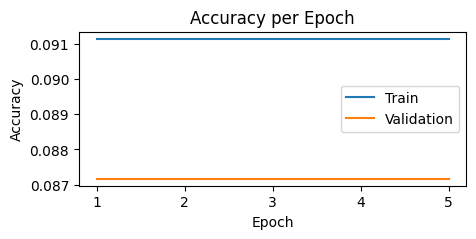

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.xticks(ticks=range(0,5), labels=list(range(1,6)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

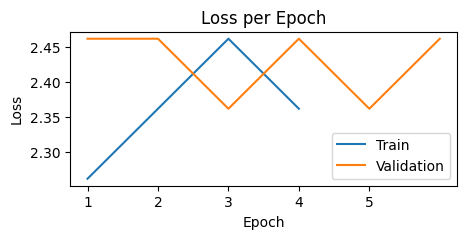

In [ ]:
plt.figure(figsize=(5,2))
plt.plot([train_losses[i-1] for i in range(5000, len(train_losses)+1, 5000)], label="Train")
plt.plot([val_losses[i-1] for i in range(1000, len(val_losses)+1, 1000)], label="Validation")
plt.xticks(ticks=range(0,5), labels=list(range(1,6)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

*Let's test our poor excuse of a model*

In [ ]:
true_labels = []
pred_labels = []

with torch.no_grad():
    for b, (x_test, y_test) in enumerate(test_loader):

        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_pred = model(x_test)
        test_pred_vec = torch.max(test_pred.data, 1)[1]

        true_labels.append(y_test)
        pred_labels.append(test_pred_vec)

In [ ]:
true_labels = torch.cat(true_labels, dim=0)
pred_labels = torch.cat(pred_labels, dim=0)

In [ ]:
#Creating Confusion Matrix
[v for k,v in train_data.class_to_idx.items()]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:3}'))
print(np.array([v for k,v in train_data.class_to_idx.items()]), '\n')
print(confusion_matrix(true_labels.to('cpu'), pred_labels.to('cpu')))

[  0   1   2   3   4   5   6   7   8   9] 

[[  0   0   0   0   0 980   0   0   0   0]
 [  0   0   0   0   0 1135   0   0   0   0]
 [  0   0   0   0   0 1032   0   0   0   0]
 [  0   0   0   0   0 1010   0   0   0   0]
 [  0   0   0   0   0 982   0   0   0   0]
 [  0   0   0   0   0 892   0   0   0   0]
 [  0   0   0   0   0 958   0   0   0   0]
 [  0   0   0   0   0 1028   0   0   0   0]
 [  0   0   0   0   0 974   0   0   0   0]
 [  0   0   0   0   0 1009   0   0   0   0]]


*Funny enough, it only guesses 5. Let's finally assess the misses.*

In [ ]:
misses = np.array([])
missed_label = np.array([])

for i in range(len(pred_labels.to('cpu'))):
    if pred_labels[i] != true_labels.to('cpu')[i]:
        misses = np.append(misses,i).astype('int64')
        missed_label = np.append(missed_label, true_labels.to('cpu')[i]).astype('int64')

len(misses)


9108

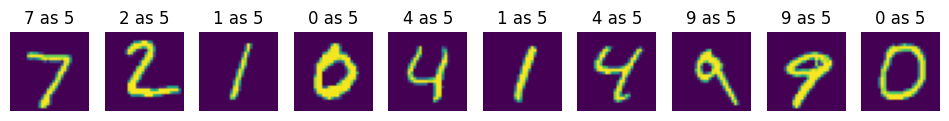

In [ ]:
wrong = [pred_labels[i].item() for i in misses[:10]]
missed_images = [test_loader.dataset[j][0] for j in [i for i in misses[:10]]]
fig, axs = plt.subplots(1, len(missed_images), figsize=(12, 2))

c = 0
for i in missed_images:
    axs[c].imshow(i.view(28, 28), vmin=0, vmax=1)
    axs[c].axis('off')
    axs[c].set_title(f"{missed_label[c]} as {wrong[c]}")
    c += 1
plt.show()

Therefore we imply that an appropriate pipeline and setup should be observed in model training as poor understanding may result to a very underwhelming performance.